In [ ]:
# %load Dataproject.py
"""
write this in the Terminal:
conda install -c anaconda pandas-datareader

When asked:
The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates                                 pkgs/main --> anaconda
  certifi                                         pkgs/main --> anaconda
  openssl                                         pkgs/main --> anaconda
  qt                                              pkgs/main --> anaconda
Proceed ([y]/n)?

Press y
"""
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
import pandas as pd
import pandas_datareader as web
import numpy as np
import bs4 as bs
import pickle
import requests
import os
import pickle
import numpy as np
from scipy.stats import norm # normal distribution
import matplotlib.pyplot as plt
import ipywidgets as widgets
style.use("ggplot")

The purpose of the code below is to first get the tickers for each of the companites on the S&P500 index list, which we later on will
use to append all the historic data to the appropriate ticker. We use *requests.get* to access the data from Wikipedia, which is the list of tickers, after which we use *BeautifulSoup* to then read the HTML format of the website, and make a table. The *soup.find* command is used to specify where exactly in the HTML the table we want is located. 

We make an empty list, and use a for loop to read all entries in the column of the tickers and append each of these to the list we made (called tickers). 

We save it as a pickle as we want to access this data later on, and fast. We called this *"sp500tickers.pickle"*. 



In [16]:
#Automating S&P500 - From Yahoo Finance - Close price adjusted for splits, and Adj. Close price is adjusted for both dividends and splits.
def save_sp500_tickers():
    resp = requests.get("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
    soup = bs.BeautifulSoup(resp.text, "lxml")
    table = soup.find("table", {"class": "wikitable sortable"})
    tickers = []
    for row in table.findAll("tr")[1:]:
        ticker = row.findAll("td")[1].text.replace(".","-")
        tickers.append(ticker)

    with open("sp500tickers.pickle", "wb") as f:
        pickle.dump(tickers, f)
    
        print(tickers)

        return(tickers)
    

save_sp500_tickers()

Next, we need data for each ticker we have in the list. We get this from yahoo, and using the *DataReader* from pandas. 

Remember we saved the tickers as a pickle file, which we will now open and use to append the data to. Also, we make a separate folder for all of the CSV files we will get (505!). We define appropriate start and end dates for the data we want. 

We then create a for loop, and save each CSV file with price data in the stock_dfs folder. 

In [16]:
#Getting data from Yahoo
def data_yahoo(reload_sp500=False):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open("sp500tickers.pickle", "rb") as f:
            tickers = pickle.load(f)
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')

    start = dt.datetime(2000, 1, 1)
    end = dt.datetime.now()
    for ticker in tickers:
        # just in case your connection breaks, we'd like to save our progress!
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            df = web.DataReader(ticker, 'yahoo', start, end)
            df.to_csv('stock_dfs/{}.csv'.format(ticker))
        else:
            print('Already have {}'.format(ticker))

data_yahoo()

Furthermore, the data from yahoo and the tickers are not very useful by themselves, so obvisouly we want to compile the data in order to get a dataframe with all tickers and their data. We open the pickle file again, and make an empty dataframe.

We can then compile each ticker with their data. We drop all columns that are not *Adj Close*, and rename *Adj Close* to the ticker name since we do not have any other data than for Adjusted Close price. We choose to only include this, since the Adjusted Close price takes into account payment of dividends of companies, eventual stock splits, and Rights offerings.

For easier comparison, we also index the data by dividing the first observation in each column by the rest of the column. 

We then use the empty data frame made before, and join all the data together into a single data frame. 

We also convert the data frame to a csv file for easy access to it. 

finally, we create a data frame from the CSV file just saved, and index the date. We call this new data frame *df_stocks*.

In [17]:
def compile_data():
    with open("sp500tickers.pickle", "rb") as f:
        tickers = pickle.load(f)

    main_df = pd.DataFrame()

    #Iterating though all DFs

    for count, ticker in enumerate(tickers):
        df = pd.read_csv("stock_dfs/{}.csv".format(ticker))
        df.set_index("Date", inplace=True)
        df.rename(columns = {"Adj Close": ticker}, inplace=True) #Adj Close takes the categories place in the column - Simple rename
        df.drop(["Open","High","Low","Close","Volume"],1, inplace=True)
        df = df.divide(df.iloc[0])*100

        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df, how="outer")
        
        if count % 10 == 0: #Only print #10, #20, #30, etc.
            print(count)
    print(main_df.head())
    main_df.to_csv("sp500_joined_adj_closes.csv")

compile_data()

df_stocks = pd.read_csv("sp500_joined_adj_closes.csv")
df_stocks.set_index("Date", inplace=True)

print(df_stocks)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
                   MMM         ABT  ABBV        ABMD  ACN        ATVI  \
Date                                                                    
2000-01-03  100.000000  100.000000   NaN  100.000000  NaN  100.000000   
2000-01-04   96.026507   97.142840   NaN   97.602740  NaN   96.958177   
2000-01-05   98.807956   96.964254   NaN   98.630137  NaN   97.338401   
2000-01-06  106.754977  100.357158   NaN   98.801370  NaN   95.437260   
2000-01-07  108.874219  101.428552   NaN   98.287671  NaN   98.098859   

                  ADBE         AMD  AAP         AES ...   WLTW  WYNN  \
Date                                                ...                
2000-01-03  100.000000  100.000000  NaN  100.000000 ...    NaN   NaN   
2000-01-04   91.611085   94.354839  NaN   96.034474 ...    NaN   NaN   
2000-01

As we want to compare a stock from the S&P500 index by the index itself, we need the index data as a whole by itself. We get this using the same method as earlier. We appened this to the Data frame from the compile function. 

In [16]:
#Get sp500 index data

Index_data = web.DataReader("^GSPC", data_source="yahoo", start="1,1,2000")
Index_data.to_csv("IndexData.csv")

df_index_data = pd.read_csv("IndexData.csv", index_col = "Date", parse_dates=True)
df_index_data.rename(columns = {"Adj Close": "S&P500"}, inplace=True)

df_index_data_new = df_index_data["S&P500"]

df_index_data_new = df_index_data_new/df_index_data_new[0]*100

df_final = df_stocks.join(df_index_data_new, how="left")
print(df_final)



We then want to graph a single stock and compare it to the growth of the index as a whole. We start by making a copy of the data we have, using only *"ATVI"* and the *"S&P500"* data. 

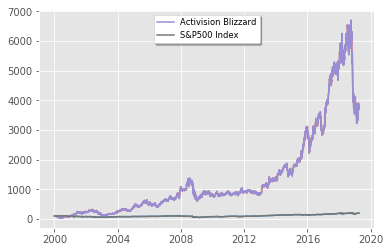

In [19]:
ydata = df_final[["ATVI", "S&P500"]].copy()

plt.plot(ydata)

def plot():

    df = df_final
    
    plt.plot(df["ATVI"], label = "Activision Blizzard")
    plt.plot(df["S&P500"], label = "S&P500 Index")

    plt.legend(loc = "upper center", shadow = True, fontsize = "small", facecolor = "white")

    plt.show()


plot()

On the graph above, we see the growth in the Activision Blizzard stock compared to the S&P500 index. We see that the Activision Blizzard stock has experience a wild growth since its start in 2000. The spike around 2008 is due to the merge between Activision Entertainment and Blizzard Entertainment. The rise since ca. 2013 can be due to the rise in popularity and availability to video games. The eventual drastic fall in the end of the series comes after Blizzcon 2018 where a very unpopular annoucement was made, and a dissappointing earnings call in the 3rd quarter, resulting in a strong fall in the stock price. 